In [1]:
from google.colab import drive
import os
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!pwd
%cd /content/drive/MyDrive/LSTM\ project/LSTM/sector_analysis(food drug)

/content
/content/drive/MyDrive/LSTM project/LSTM/sector_analysis(food drug)


# Full Function 

In [3]:
# Make a comprehensive function 
from keras.layers import *
def multi_stock_analysis(c, nl, v, V=False, output_c='High', output_i=1, train_size=754, time_step=60, epochs=30): 
  import warnings
  warnings.simplefilter('ignore')
  import math
  import seaborn as sns
  import matplotlib.pyplot as plt
  import keras
  import pandas as pd
  import numpy as np
  from keras.models import Sequential
  from keras.layers import Dense
  from keras.layers import LSTM
  from keras.layers import Dropout
  from sklearn.preprocessing import MinMaxScaler
  from sklearn.preprocessing import StandardScaler
  from sklearn.metrics import mean_squared_error
  from sklearn.metrics import mean_absolute_error
  from sklearn.model_selection import train_test_split
  from keras.callbacks import EarlyStopping
  
  #1. split train and test data
  train_data=[]
  test_data=[]
  for i in range(len(c)):
    train_data.append(c[i].iloc[: train_size, v].values)
    test_data.append(c[i].iloc[train_size:, v].values)
  print("finish split data")

  #2. train_data->normalise depending on number of inputs (only the volume is processed separately as the scale is different)
  #3. make X_train, y_train flexibly
  X_train=[]
  y_trains=[]
  
  if V:
    print("volume=TRUE")
    training_set_others=np.hstack((data[:,:-1] for data in train_data))
    training_set_volume=np.hstack((data[:,-1:].reshape(-1, 1) for data in train_data))

    ss1=StandardScaler()
    ss_others=ss1.fit_transform(training_set_others)
    ss2=StandardScaler()
    ss_v=ss2.fit_transform(training_set_volume)
    concat=np.hstack((ss_others, ss_v))
    
    ind=[i for i in range(output_i, training_set_others.shape[1], len(v)-1)]
    print(f"ind={ind}")

    for j in range(time_step, 754):
      X_train.append(concat[j-time_step: j, :])
      for k in range(len(ind)):
        y_trains.append(concat[j, ind[k]])

  else:
    training_set=np.hstack((data for data in train_data))
    print(f"training_set={training_set.shape}")
    ss1=StandardScaler()
    ss_all=ss1.fit_transform(training_set)

    ind=[i for i in range(output_i, training_set.shape[1], len(v))]
    print(f"ind={ind}")

    for j in range(time_step, 754):
      X_train.append(ss_all[j-time_step: j, :])
      for k in range(len(c)):
        y_trains.append(ss_all[j, ind[k]])

  X_train=np.array(X_train)
  y_trains=np.array(y_trains)
  print(f"X_train={X_train.shape}, y_trains={y_trains.shape}")
  print("finish making X_train and y_trains")

  #3. train models
  y_trains2=[]
  for y in range(len(c)):
    y_tr=np.array([y_trains[i] for i in range(y, len(y_trains), len(c))])
    y_trains2.append(y_tr)

  y_trains2=np.array(y_trains2)
  print(f"y_trains2={y_trains2[0].shape}")

  
  model_lists = []
  for l in range(len(y_trains2)):
    print(f"{l+1}/{len(y_trains2)}")
    model = Sequential()
    #Adding the first LSTM layer and some Dropout regularisation
    # ここのinput_shapeで入力次元を設定する
    model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
    model.add(Dropout(0.2))
    # Adding a second LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a third LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50, return_sequences = True))
    model.add(Dropout(0.2))
    # Adding a fourth LSTM layer and some Dropout regularisation
    model.add(LSTM(units = 50))
    model.add(Dropout(0.2))
    # Adding the output layer
    model.add(Dense(units = 1))

    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    # Fitting the RNN to the Training set
    model.fit(X_train, y_trains2[l], epochs = epochs, batch_size = 32)
    model_lists.append(model)
    print("")
  print("finish making models")

  #4. Prepare test data and normalise and make predictions
  inputs = []
 
  for m in range(len(c)):
    inputs.append(c[m].iloc[:, v][len(c[m])-len(test_data[m])-time_step:].values)
  print(f"inputs={inputs[0][0]}")


  if V:
    ex = [i for i in range(len(v)-1)]
    ex.pop(output_i)
    print(ex)
  else: 
    ex = [i for i in range(len(v))]
    ex.pop(output_i)

  con = np.hstack((inp[:, ex] for inp in inputs))
  print(f"con={con.shape}")
  
  if V:
    ss_lists = [tar[:, output_i].reshape(-1, 1) for tar in inputs] + [vol[:, -1].reshape(-1, 1) for vol in inputs]
    if con.shape[1] !=0:
      ss_lists.append(con)
    print(f"ss_lists={len(ss_lists)}")
  else: 
    ss_lists = [tar[:, output_i].reshape(-1, 1) for tar in inputs]
    ss_lists.append(con)
    print(f"ss_lists={len(ss_lists)}")   

  x = []
  ss = []
  for i in range(len(ss_lists)):
    s=StandardScaler() 
    print(ss_lists[i].shape)
    m=s.fit_transform(ss_lists[i])
    x.append(m)
    ss.append(s)
  inputs2=np.hstack((sx for sx in x))
  # print(f"inputs2={inputs2}")

  X_test = []
  # use all components as a imputs for testing
  for n in range(60, 312):
    X_test.append(inputs2[n-time_step:n, :])

  X_test = np.array(X_test)
  print(f"X_test={X_test.shape}")

  preds = []
  for o in range(len(y_trains2)):
    preds.append(np.array(model_lists[o].predict(X_test)))

  for p in range(len(y_trains2)):
    preds[p] = ss[p].inverse_transform(preds[p])

  print("finish making predictions")
  #5. Plot actual vs preds
  # df ={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6] 
  actual_lists=[sc.iloc[train_size:, output_i+1: output_i+2] for sc in c]
  print("1")
  R2=nl
  
  for p in range(len(R2)):
    plt.figure(figsize=(10, 6)) 
    print("2")
    print(f"actual lists={actual_lists[p].shape}, preds_list={preds[p].shape}")
    plt.plot(c[p].loc[train_size:,'Date'], actual_lists[p], color='red', label='Real')
    plt.plot(c[p].loc[train_size:,'Date'], preds[p], color='blue', label='Predict')
    print("3")
    from sklearn.metrics import r2_score

    plt.xticks(np.arange(0, 300, 30))
    plt.title(nl[p])
    plt.xlabel('Time series')
    plt.ylabel('Stock Price')
    
    # use spearman's correlation
    print(f"R2[{R2[p]}]={r2_score(actual_lists[p], preds[p].flatten())}")
    plt.legend()
    plt.show()
  
  #6. Make confusion matrix

  columns = nl # labeling 
  # Actual 
  print("Actual")
  act=[a for a in actual_lists]
  Actual=pd.concat(act, axis=1)
  Actual.columns = columns
  plt.figure(figsize=(8, 6))
  cmap=sns.diverging_palette(220, 20, as_cmap=True)
  sns.heatmap(Actual.corr(method='spearman'), cmap=cmap, annot=True) 

  # Predictions
  print("Prediction")
  prd=[p for p in preds]
  Preds= pd.DataFrame(np.concatenate(prd, axis=1))
  Preds.columns = columns
  plt.figure(figsize=(8, 6))
  cmap=sns.diverging_palette(220, 20, as_cmap=True)
  sns.heatmap(Preds.corr(method='spearman'), cmap=cmap, annot=True) 

  """Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """

# "Eeperiments"
###Sector: Food & Drug store
### Criteria: Revenue/Employees 

In [6]:
# sector-> Food & Drug store(2017/01/01~2020/12/31) 
import pandas as pd
df1=pd.read_csv("SVNDY.csv") #Seven & I Holdings (Japan) 0.62$
df2=pd.read_csv("WBA.csv")   #Walgreens Boots Alliance (USA) 0.48$
df3=pd.read_csv("MTRAF.csv") #Metro (Canada) 0.42$
df4=pd.read_csv("COOP.csv")  #Coop Group (Switzerland) 0.38$
df5=pd.read_csv("JSAIY.csv")  #J.Sainsbury(Britain) 0.33$
df6=pd.read_csv("ADRNY.csv")  #Royal Ahold Delhaize(Netherlands) 0.32$
df7=pd.read_csv("TSCDY.csv")  #Tesco(Britain) 0.28$
df8=pd.read_csv("KR.csv")    #Kroger(USA) 0.28$
df9=pd.read_csv("AGHC.csv")  #AEON(Japan) 0.27$
df10=pd.read_csv("CRRFY.csv") #Carrefour(France) 0.27$
df11=pd.read_csv("WNGRF.csv") #George Weston(Canada) 0.19$
print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape, df6.shape, df7.shape, df8.shape, df9.shape, df10.shape, df11.shape)
print(f"df1={df1[0:1]}")
print(f"df2={df2[0:1]}")
print(f"df3={df3[0:1]}")
print(f"df4={df4[0:1]}")
print(f"df5={df5[0:1]}")
print(f"df6={df6[0:1]}")
print(f"df7={df7[0:1]}")
print(f"df8={df8[0:1]}")
print(f"df9={df9[0:1]}")

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)
df1=         Date   Open       High    Low  Close  Adj Close  Volume
0  2017-01-03  18.92  19.200001  18.91  19.01      19.01   77500
df2=         Date       Open       High        Low      Close  Adj Close   Volume
0  2017-01-03  83.099998  83.379997  82.300003  82.959999  73.058113  4942700
df3=         Date       Open       High        Low      Close  Adj Close  Volume
0  2017-01-03  29.719999  29.719999  29.719999  29.719999   27.86932       0
df4=         Date       Open       High   Low  Close  Adj Close  Volume
0  2017-01-03  19.200001  19.200001  17.4   18.6       18.6   76267
df5=         Date   Open   High    Low  Close  Adj Close  Volume
0  2017-01-03  12.42  12.43  12.32  12.34  10.379322   85600
df6=         Date       Open   High        Low  Close  Adj Close  Volume
0  2017-01-03  20.690001  20.82  20.620001  20.82   18.79217  119000
df7=         Date      Open   

2
finish split data
volume=TRUE
ind=[2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42]
X_train=(694, 60, 55), y_trains=(7634,)
finish making X_train and y_trains
y_trains2=(694,)
1/11
22/22 [==============================] - 8s 102ms/step - loss: 0.5818

2/11
22/22 [==============================] - 8s 110ms/step - loss: 0.4306

3/11
22/22 [==============================] - 8s 99ms/step - loss: 0.4345

4/11
22/22 [==============================] - 8s 100ms/step - loss: 0.5282

5/11
22/22 [==============================] - 8s 102ms/step - loss: 0.6662

6/11
22/22 [==============================] - 8s 104ms/step - loss: 0.6083

7/11
22/22 [==============================] - 8s 100ms/step - loss: 0.5568

8/11
22/22 [==============================] - 8s 100ms/step - loss: 0.4567

9/11
22/22 [==============================] - 8s 100ms/step - loss: 0.2629

10/11
22/22 [==============================] - 8s 105ms/step - loss: 0.5947

11/11
22/22 [==============================] - 8s 99ms/step - loss: 0

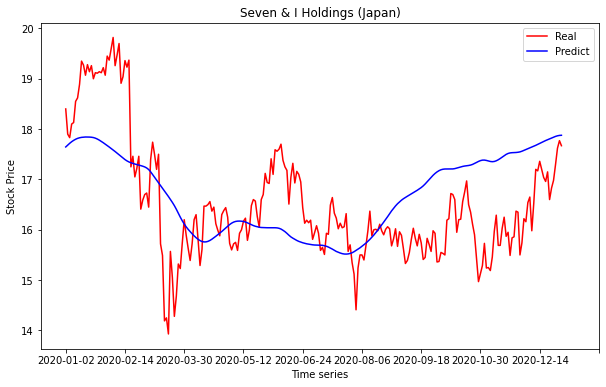

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Walgreens Boots Alliance (USA)]=-1.8382872209720702


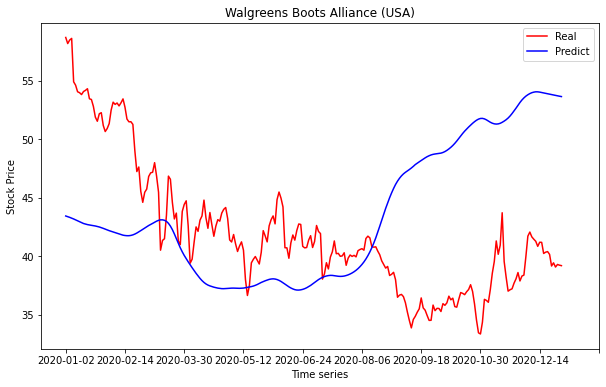

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Metro (Canada)]=-0.38177815259621517


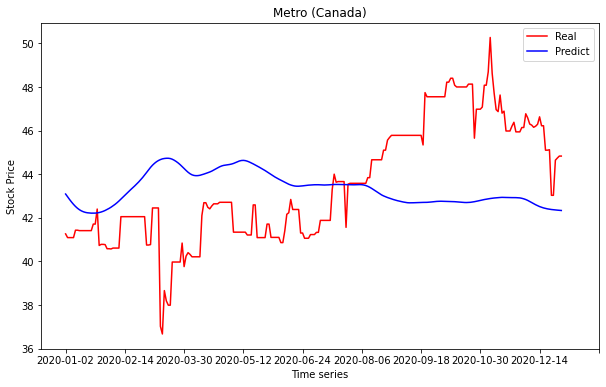

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Coop Group (Switzerland)]=0.026924372709803412


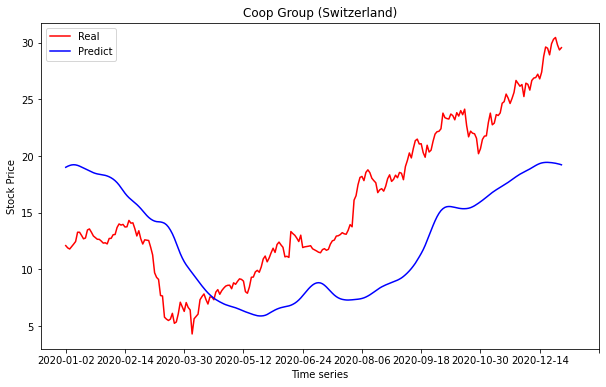

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[J.Sainsbury(Britain)]=-0.20654824535730532


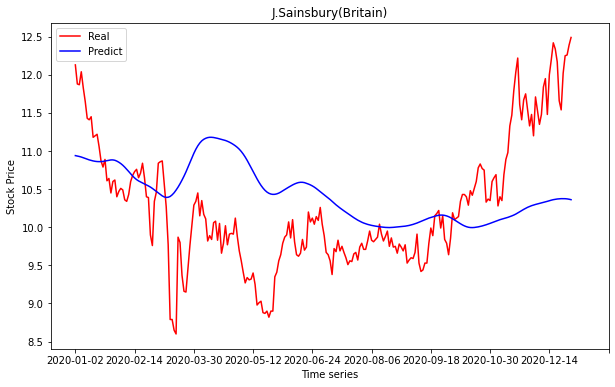

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Royal Ahold Delhaize(Netherlands)]=0.050790078348015966


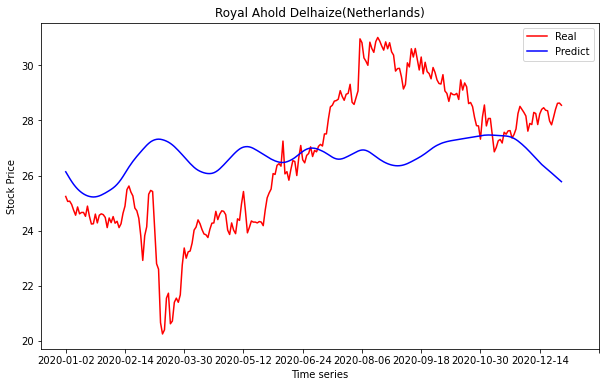

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Tesco(Britain)]=-0.2763264747064631


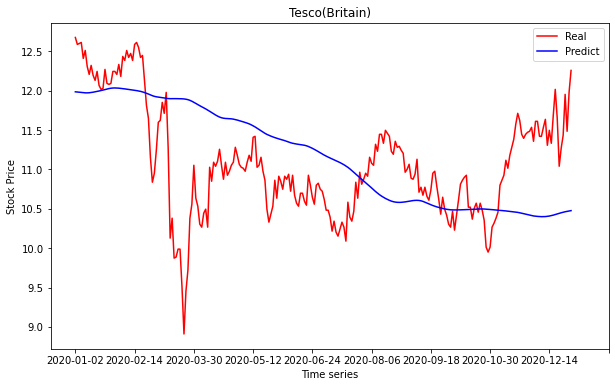

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Kroger(USA)]=-0.9145000964368288


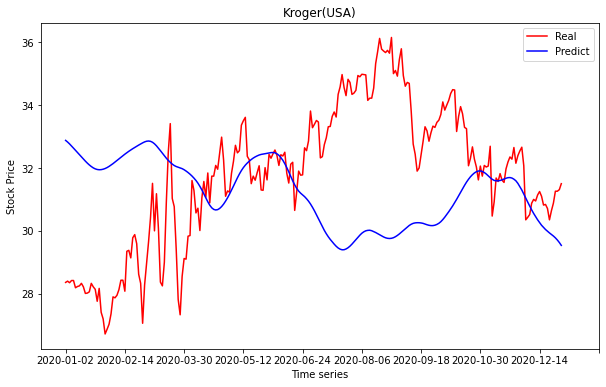

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[AEON(Japan)]=-1.142638726519087


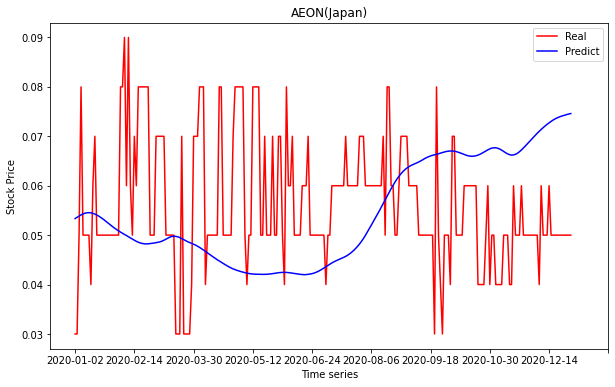

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[Carrefour(France)]=-0.09870908451342864


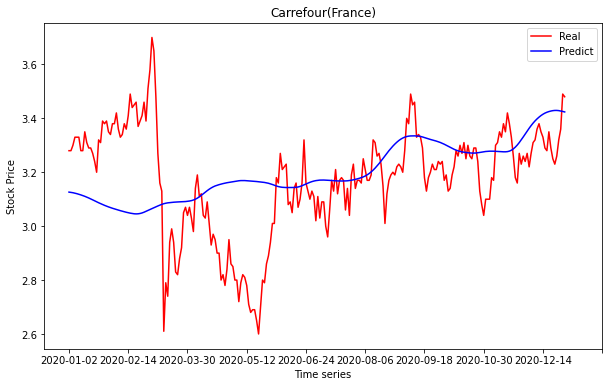

2
actual lists=(252, 1), preds_list=(252, 1)
3
R2[George Weston(Canada)]=0.1389833314982608


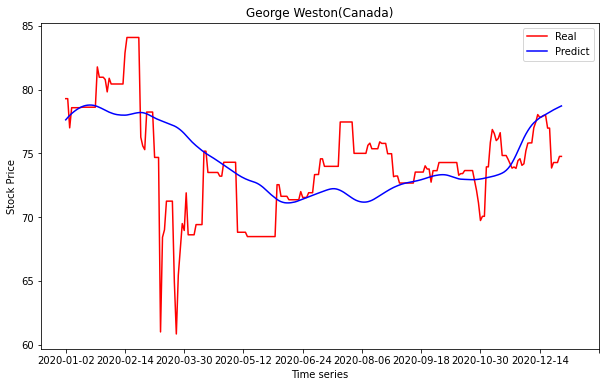

Actual
Prediction


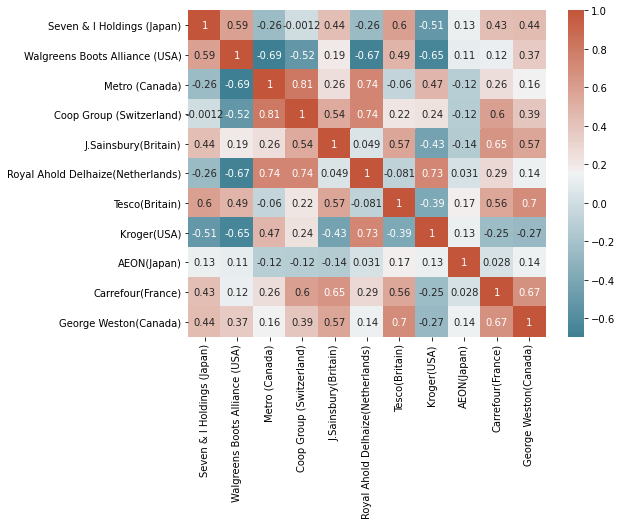

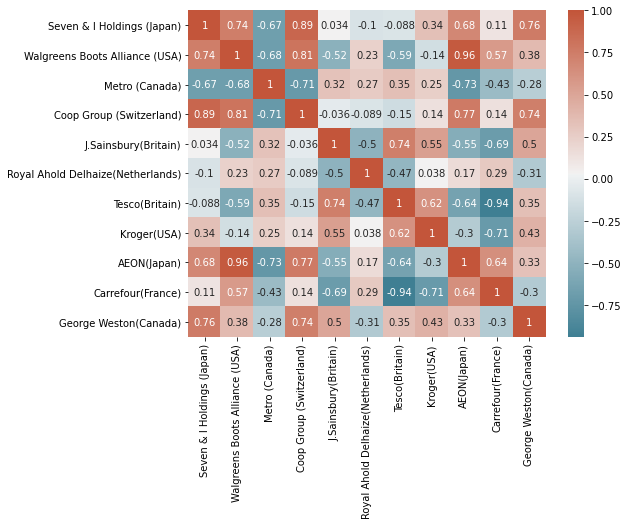

In [ ]:
c=[df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11]
nl=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", 'Coop Group (Switzerland)', 'J.Sainsbury(Britain)',
    "Royal Ahold Delhaize(Netherlands)", "Tesco(Britain)", "Kroger(USA)", "AEON(Japan)", "Carrefour(France)", "George Weston(Canada)"]
items={"Date":0, "Open":1, "High":2, "Low":3, "Close":4, "Adj Close":5, "Volume":6}
# Basically, we can remove "Date" and "Adj Close"
v=[1, 2, 3, 4, 6]  # item' index chosen as imputs
output_c='High' # output item
output_i=2
print(output_i)

# V means whether "Volume" may be included or not
if 6 not in v:
  V=False
else: V=True

multi_stock_analysis(c, nl, v, V=V, output_c=output_c, output_i=output_i, train_size=754, time_step=60, epochs=1)

# Separate functions

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
# sector-> Food & Drug store (2017/01/01~2020/12/31)
df1=pd.read_csv("SVNDY.csv") #Seven & I Holdings (Japan) 0.62$
df2=pd.read_csv("WBA.csv")   #Walgreens Boots Alliance (USA) 0.48$
df3=pd.read_csv("MTRAF.csv") #Metro (Canada) 0.42$
df4=pd.read_csv("COOP.csv")  #Coop Group (Switzerland) 0.38$
df5=pd.read_csv("JSAIY.csv")  #J.Sainsbury(Britain) 0.33$
print(df1.shape, df2.shape, df3.shape, df4.shape, df5.shape)
df4.tail()

(1006, 7) (1006, 7) (1006, 7) (1006, 7) (1006, 7)


,Date,Open,High,Low,Close,Adj Close,Volume
1001,2020-12-23,30.559999,31.120001,30.290001,30.950001,30.950001,831000
1002,2020-12-24,31.030001,31.120001,30.450001,30.600000,30.600000,285000
1003,2020-12-28,30.830000,30.950001,29.799999,29.969999,29.969999,763900
1004,2020-12-29,29.930000,30.080000,29.350000,29.920000,29.920000,585400
1005,2020-12-30,30.020000,31.049999,29.549999,30.549999,30.549999,622400


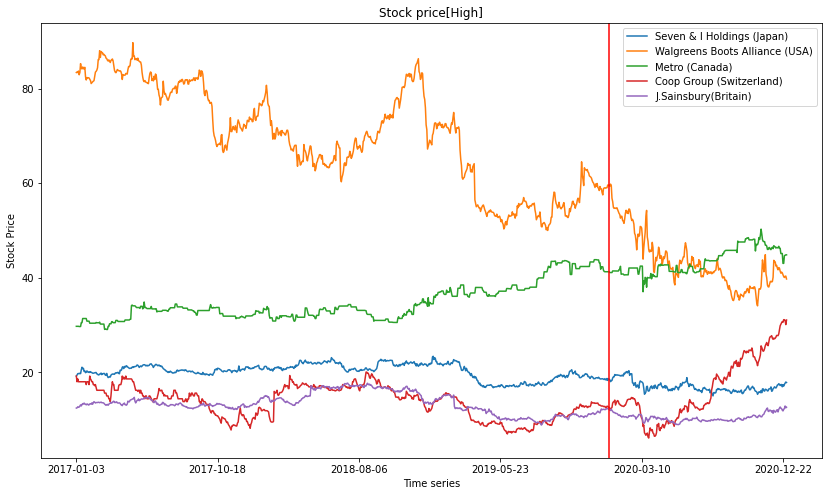

In [ ]:
plt.figure(figsize=(14, 8))
plt.plot(df1.loc[:,'Date'], df1.loc[:,'High'], label='Seven & I Holdings (Japan)')
plt.plot(df2.loc[:,'Date'], df2.loc[:,'High'], label='Walgreens Boots Alliance (USA)')
plt.plot(df3.loc[:,'Date'], df3.loc[:,'High'], label='Metro (Canada)')
plt.plot(df4.loc[:,'Date'], df4.loc[:,'High'], label='Coop Group (Switzerland)')
plt.plot(df5.loc[:,'Date'], df5.loc[:,'High'], label='J.Sainsbury(Britain)')
plt.title('Stock price[High]')
plt.xticks(np.arange(0, 1006, 200))
plt.axvline(x=df1.loc[754,'Date'], ymin=0, ymax=100, c="red")
plt.xlabel('Time series')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [ ]:
# extraxt training data
df1_tr=df1.iloc[:754, [1,2,3,4,6]].values
df1_ts=df1.iloc[754:, [1,2,3,4,6]].values

df2_tr=df2.iloc[:754, [1,2,3,4,6]].values
df2_ts=df2.iloc[754:, [1,2,3,4,6]].values

df3_tr=df3.iloc[:754, [1,2,3,4,6]].values
df3_ts=df3.iloc[754:, [1,2,3,4,6]].values

df4_tr=df4.iloc[:754, [1,2,3,4,6]].values
df4_ts=df4.iloc[754:, [1,2,3,4,6]].values

df5_tr=df5.iloc[:754, [1,2,3,4,6]].values
df5_ts=df5.iloc[754:, [1,2,3,4,6]].values

In [ ]:
df1_tr.shape

(754, 5)

In [ ]:
training_set_others=np.hstack((df1_tr[:,0:4], df2_tr[:,0:4], df3_tr[:,0:4], df4_tr[:,0:4], df5_tr[:,0:4], ))
# (754, 20)
training_set_volume=np.hstack((df1_tr[:,4].reshape(-1, 1), df2_tr[:,4].reshape(-1, 1), df3_tr[:,4].reshape(-1, 1), df4_tr[:,4].reshape(-1, 1), df5_tr[:,4].reshape(-1, 1)))
# (754, 5)

# feature scaling
s4=StandardScaler()
scaled_training_others=s4.fit_transform(training_set_others)

s1=StandardScaler()
scaled_training_volume=s1.fit_transform(training_set_volume)

hstack = np.hstack((scaled_training_others, scaled_training_volume))
# (754, 25)

In [ ]:
# Creating a data structure with 60 time-steps
X_train=[]
y1_train=[]
y2_train=[]
y3_train=[]
y4_train=[]
y5_train=[]

for i in range(60, 754):
  X_train.append(hstack[i-60: i, :])
  # only choose 'HIgh' label
  y1_train.append(hstack[i, 1])
  y2_train.append(hstack[i, 5])
  y3_train.append(hstack[i, 9])
  y4_train.append(hstack[i, 13])
  y5_train.append(hstack[i, 17])

X_train=np.array(X_train)
y1_train=np.array(y1_train)
y2_train=np.array(y2_train)
y3_train=np.array(y3_train)
y4_train=np.array(y4_train)
y5_train=np.array(y5_train)
X_train.shape

(694, 60, 25)

In [ ]:
model_list = []
y_train = [y1_train, y2_train, y3_train, y4_train, y5_train]

for i in range(len(y_train)):
  print(f"{i+1}/{len(y_train)}")
  model = Sequential()
  #Adding the first LSTM layer and some Dropout regularisation
  # ここのinput_shapeで入力次元を設定する
  model.add(LSTM(units = 50, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2] )))
  model.add(Dropout(0.2))
  # Adding a second LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  # Adding a third LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50, return_sequences = True))
  model.add(Dropout(0.2))
  # Adding a fourth LSTM layer and some Dropout regularisation
  model.add(LSTM(units = 50))
  model.add(Dropout(0.2))
  # Adding the output layer
  model.add(Dense(units = 1))

  # Compiling the RNN
  model.compile(optimizer = 'adam', loss = 'mean_squared_error')

  # Fitting the RNN to the Training set
  model.fit(X_train, y_train[i], epochs = 10, batch_size = 32)
  model_list.append(model)
  print("")

1/5
Epoch 1/10
22/22 [==============================] - 9s 117ms/step - loss: 0.5376
Epoch 2/10
22/22 [==============================] - 3s 116ms/step - loss: 0.1356
Epoch 3/10
22/22 [==============================] - 3s 119ms/step - loss: 0.0864
Epoch 4/10
22/22 [==============================] - 3s 116ms/step - loss: 0.0732
Epoch 5/10
22/22 [==============================] - 3s 116ms/step - loss: 0.0705
Epoch 6/10
22/22 [==============================] - 3s 119ms/step - loss: 0.0700
Epoch 7/10
22/22 [==============================] - 3s 117ms/step - loss: 0.0648
Epoch 8/10
22/22 [==============================] - 3s 113ms/step - loss: 0.0675
Epoch 9/10
22/22 [==============================] - 3s 114ms/step - loss: 0.0572
Epoch 10/10
22/22 [==============================] - 3s 118ms/step - loss: 0.0591

2/5
Epoch 1/10
22/22 [==============================] - 8s 111ms/step - loss: 0.4069
Epoch 2/10
22/22 [==============================] - 2s 113ms/step - loss: 0.0817
Epoch 3/10
22/22 [

In [ ]:
# Getting the predicted stock price 

# Getting the predicted stock price 
_df1_tr=df1.iloc[:754, [1,2,3,4,6]]
_df1_ts=df1.iloc[754:, [1,2,3,4,6]]
_df2_tr=df2.iloc[:754, [1,2,3,4,6]]
_df2_ts=df2.iloc[754:, [1,2,3,4,6]]
_df3_tr=df3.iloc[:754, [1,2,3,4,6]]
_df3_ts=df3.iloc[754:, [1,2,3,4,6]]
_df4_tr=df4.iloc[:754, [1,2,3,4,6]]
_df4_ts=df4.iloc[754:, [1,2,3,4,6]]
_df5_tr=df5.iloc[:754, [1,2,3,4,6]]
_df5_ts=df5.iloc[754:, [1,2,3,4,6]]
print(_df1_tr.shape)

dataset_total_1= pd.concat((_df1_tr, _df1_ts), axis = 0) 
dataset_total_2 = pd.concat((_df2_tr, _df2_ts), axis = 0) 
dataset_total_3 = pd.concat((_df3_tr, _df3_ts), axis = 0) 
dataset_total_4 = pd.concat((_df4_tr, _df4_ts), axis = 0) 
dataset_total_5 = pd.concat((_df5_tr, _df5_ts), axis = 0) 
print(dataset_total_1.shape)

# ここで、test用にのデータを改めて作成している
inputs_1 = dataset_total_1[len(dataset_total_1) - len(_df1_ts) - 60:].values
inputs_2 = dataset_total_2[len(dataset_total_2) - len(_df2_ts) - 60:].values
inputs_3 = dataset_total_3[len(dataset_total_3) - len(_df3_ts) - 60:].values
inputs_4 = dataset_total_4[len(dataset_total_4) - len(_df4_ts) - 60:].values
inputs_5 = dataset_total_5[len(dataset_total_5) - len(_df5_ts) - 60:].values
print(inputs_1.shape)

concat = np.hstack((inputs_1[:,[0,2,3]], inputs_2[:,[0,2,3]], inputs_3[:,[0,2,3]], inputs_4[:,[0,2,3]], inputs_5[:,[0,2,3]]))

# StandardScalerで１次元データを扱うときは必ず(xx, )->(xx, 1)に変換する必要がある
ss_lists = [inputs_1[:,1].reshape(-1,1), inputs_2[:,1].reshape(-1,1), inputs_3[:,1].reshape(-1,1), inputs_4[:,1].reshape(-1,1),
            inputs_5[:,1].reshape(-1,1), inputs_1[:,4].reshape(-1,1), inputs_2[:,4].reshape(-1,1),
            inputs_3[:,4].reshape(-1,1), inputs_4[:,4].reshape(-1,1), inputs_5[:,4].reshape(-1,1), concat]
x = []
ss = []
for i in range(len(ss_lists)):
  s = StandardScaler() 
  m = s.fit_transform(ss_lists[i])
  x.append(m)
  ss.append(s)


# combine all components (25variables=5compnaies*5variables) after StandardScaler
inputs2=np.hstack((x[0], x[1], x[2], x[3],x[4], x[5], x[6], x[7], x[8], x[9], x[10]))
print(f"inputs2 = {inputs2.shape}")

X_test = []
# use all components as a imputs for testing
for j in range(60, 312):
  X_test.append(inputs2[j-60:j, :])

X_test = np.array(X_test)
X_test.shape

(754, 5)
(1006, 5)
(312, 5)
inputs2 = (312, 25)


(252, 60, 25)

In [ ]:
"""y_train = [y1_train, y2_train, y3_train, y4_train, y5_train]]"""
preds = []

for i in range(5):
  preds.append(np.array(model_list[i].predict(X_test)))

for j in range(5):
  preds[j] = ss[j].inverse_transform(preds[j])

print(preds[0].shape)
print(preds[0][0], preds[1][0], preds[2][0], preds[3][0], preds[4][0]) 

(252, 1)
[18.597668] [39.973705] [44.304867] [17.397738] [11.045674]


R2[Seven & I Holdings (Japan)]=SpearmanrResult(correlation=0.2416886010053655, pvalue=0.00010652898707153549)


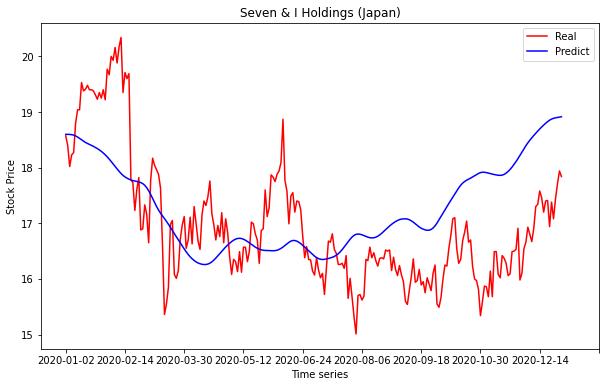

R2[Walgreens Boots Alliance (USA)]=SpearmanrResult(correlation=-0.5476525955415014, pvalue=4.011383318917165e-21)


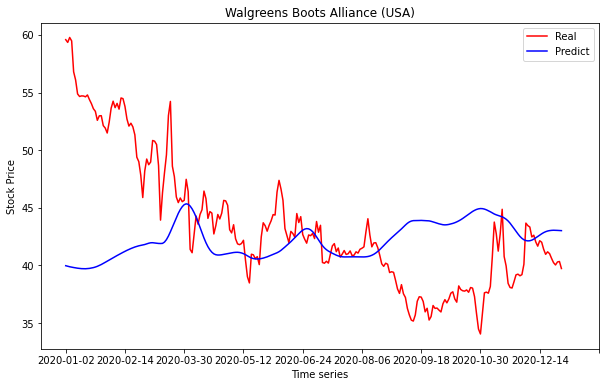

R2[Metro (Canada)]=SpearmanrResult(correlation=-0.7459520560962797, pvalue=4.976929179406165e-46)


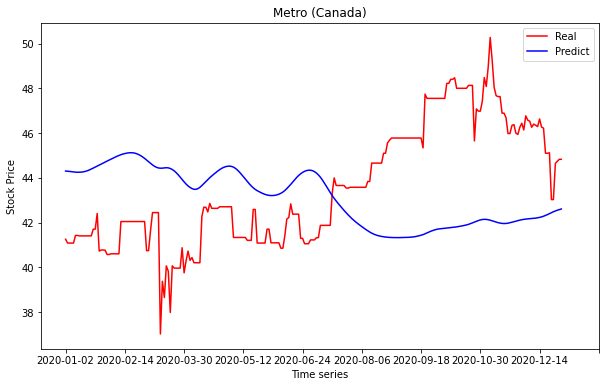

R2[Coop Group (Switzerland)]=SpearmanrResult(correlation=0.35730855250264987, pvalue=5.291244629719127e-09)


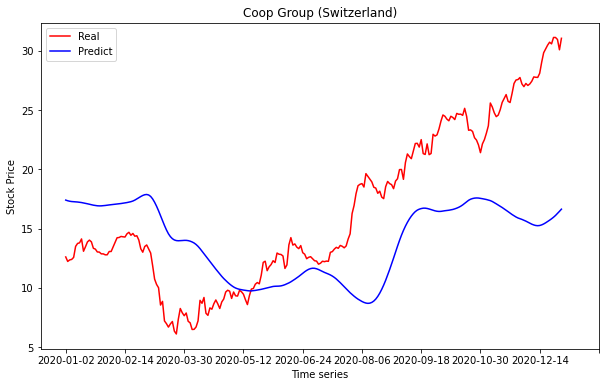

R2[J.Sainsbury(Britain)]=SpearmanrResult(correlation=0.7331599325446775, pvalue=9.377279647139134e-44)


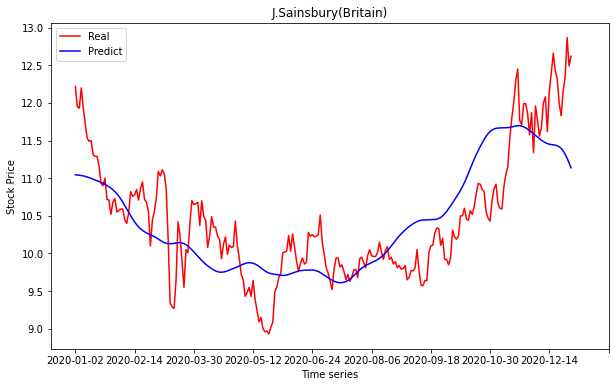

'\u3000Because there are more variables like 25 here, it is likely to get general predictions.'

In [ ]:
# Visualising the results
from scipy import stats

preds_list= preds
actual_list=[_df1_ts['High'], _df2_ts['High'], _df3_ts['High'], _df4_ts['High'], _df5_ts['High']]
title=["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)", "J.Sainsbury(Britain)"]      
R2 = ["Seven & I Holdings (Japan)", "Walgreens Boots Alliance (USA)", "Metro (Canada)", "Coop Group (Switzerland)", "J.Sainsbury(Britain)"]

for i in range(len(title)):
  plt.figure(figsize=(10, 6)) #754
  plt.plot(df1.loc[754:,'Date'], actual_list[i], color='red', label='Real')
  plt.plot(df1.loc[754:,'Date'], preds_list[i], color='blue', label='Predict')

  from sklearn.metrics import r2_score

  plt.xticks(np.arange(0, 300, 30))
  plt.title(title[i])
  plt.xlabel('Time series')
  plt.ylabel('Stock Price')
  
  # use spearman's
  print(f"R2[{R2[i]}]={stats.spearmanr(actual_list[i], preds_list[i].flatten())}")
  plt.legend()
  plt.show()

"""　Because there are more variables like 25 here, it is likely to get general predictions."""

In [ ]:
# Correlation in "High" price for the train label
# pd_concat_tr = pd.concat((df1.iloc[:,2], df2.iloc[:,2], df3.iloc[:,2], df4.iloc[:,2], df5.iloc[:,2]), axis=1)
# pd_concat_tr.columns = ['Seven', 'WBA', "Metro", 'Coop', 'Sainsbury']
pd_concat_te = pd.concat((actual_list[0], actual_list[1], actual_list[2], actual_list[3], actual_list[4]), axis=1)
pd_concat_te.columns = ['Seven', 'WBA', "Metro", 'Coop', 'Sainsbury']
np_concat= np.concatenate((preds_list[0], preds_list[1], preds_list[2], preds_list[3], preds_list[4]), axis=1)
pd_concat_pr=pd.DataFrame(np_concat)
pd_concat_pr.columns = ['Seven', 'WBA', "Metro", 'Coop', 'Sainsbury']

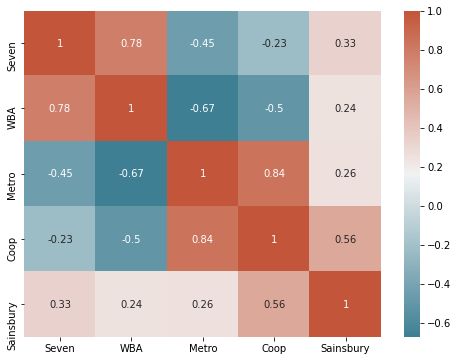

In [ ]:
import seaborn as sns
# Actual 
plt.figure(figsize=(8, 6))
cmap=sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(pd_concat_te.corr(), cmap=cmap, annot=True) 

'Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. '

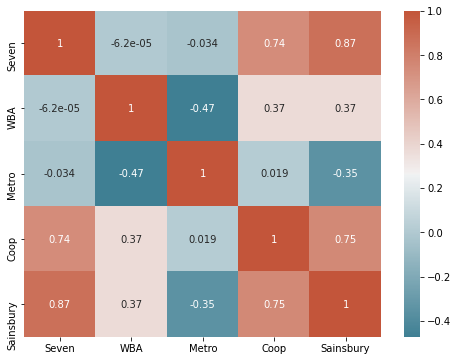

In [ ]:
# Predictions
plt.figure(figsize=(8, 6))
cmap=sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(pd_concat_pr.corr(), cmap=cmap, annot=True) 
"""Metro can be a special case, but the ohter companies in the same sector would have a sort of similarity. """